# Policy Briefing Title that Matches PDF Title

## CASA0013: Foundations of Spatial Data Science

### Student Ids: ucfther, ucftYYYY, etc.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os

from matplotlib.colors import ListedColormap

# All of these are potentially useful, though
# not all have been used in this practical --
# I'd suggest exploring the use of different 
# Scalers/Transformers as well as clustering 
# algorithms...
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_samples, silhouette_score

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

Font set up

In [2]:
tfont = {'fontname':'Liberation Sans Narrow', 'weight':'bold'}
bfont = {'fontname':'Liberation Sans Narrow', 'weight':'normal', 'horizontalalignment':'left'}
afont = {'fontname':'Liberation Sans Narrow', 'weight':'light'}

# Read in data

### caching set up

In [2]:
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 1:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

### LSOA data

In [10]:
src_url   = 'https://data.london.gov.uk/download/lsoa-atlas/0193f884-2ccd-49c2-968e-28aa3b1c480d/lsoa-data.csv'
dest_path = os.path.join('data','lsoa')

lsoa_atlas = pd.read_csv(cache_data(src_url, dest_path), encoding= 'unicode_escape')        

Found data/lsoa/lsoa-data.csv locally!


/tmp/ipykernel_27813/548347365.py:4: DtypeWarning: Columns (174,175,176,178,189,253,254) have mixed types. Specify dtype option on import or set low_memory=False.
  lsoa_atlas = pd.read_csv(cache_data(src_url, dest_path), encoding= 'unicode_escape')


In [11]:
lsoa_atlas.head(1)

,Lower Super Output Area,Names,Mid-year Population Estimates;All Ages;2001,Mid-year Population Estimates;All Ages;2002,Mid-year Population Estimates;All Ages;2003,Mid-year Population Estimates;All Ages;2004,Mid-year Population Estimates;All Ages;2005,Mid-year Population Estimates;All Ages;2006,Mid-year Population Estimates;All Ages;2007,Mid-year Population Estimates;All Ages;2008,...,Road Casualties;2012;Slight,Road Casualties;2012;2012 Total,Road Casualties;2013;Fatal,Road Casualties;2013;Serious,Road Casualties;2013;Slight,Road Casualties;2013;2013 Total,Road Casualties;2014;Fatal,Road Casualties;2014;Serious,Road Casualties;2014;Slight,Road Casualties;2014;2014 Total
0,E01000907,Camden 001A,"1,519.00","1,538.00","1,528.00","1,547.00","1,593.00","1,492.00","1,455.00","1,457.00",...,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [12]:
print(f"Shape of the LSOA Atlas data frame is: {excel_atlas.shape[0]:,} x {excel_atlas.shape[1]:,}")

Shape of the LSOA Atlas data frame is: 4,837 x 277


In [114]:
tidy = lsoa_atlas.loc[:,lsoa_atlas.columns.str.startswith(('Lower Super Output Area', 'Names','2011 Census Population','Population Density', 
                                                           'Households', 'Household Composition','Ethnic Group', 'Country of Birth',
                                                          'House Prices','Health', 'Public Transport Accessibility Levels', 'Household Income'))]

print(f"Shape of the LSOA Atlas data frame is now: {tidy.shape[0]} x {tidy.shape[1]}")

Shape of the LSOA Atlas data frame is now: 4837 x 72


In [115]:
tidy.head()

,Lower Super Output Area,Names,2011 Census Population;Age Structure;All Ages,Population Density;Area (Hectares);,Population Density;Persons per hectare;2012,Population Density;Persons per hectare;2013,Households;All households;2011,Household Composition;Couple household with dependent children;2011,Household Composition;Couple household without dependent children;2011,Household Composition;Lone parent household;2011,...,Public Transport Accessibility Levels (2014);Number of people in each PTAL level:;4,Public Transport Accessibility Levels (2014);Number of people in each PTAL level:;5,Public Transport Accessibility Levels (2014);Number of people in each PTAL level:;6a,Public Transport Accessibility Levels (2014);Number of people in each PTAL level:;6b,Public Transport Accessibility Levels (2014);Average Score;,Public Transport Accessibility Levels (2014);% 0-1 (poor access),Public Transport Accessibility Levels (2014);% 2-3 (average access),Public Transport Accessibility Levels (2014);% 4-6 (good access),"Household Income, 2011/12;Mean Annual Household Income estimate (£)","Household Income, 2011/12;Median Annual Household Income estimate (£)"
0,E01000907,Camden 001A,"1,430.00",10.70,136.00,137.00,627.00,77.00,126.00,132.00,...,439.00,217.00,0.00,0.00,4.60,0.00,54.10,45.90,"39,985.00","30,223.00"
1,E01000908,Camden 001B,"1,581.00",17.50,92.00,94.00,827.00,96.00,143.00,109.00,...,0.00,0.00,0.00,0.00,2.90,33.70,66.30,0.00,"42,394.00","32,049.00"
2,E01000909,Camden 001C,"1,614.00",22.90,70.00,72.00,661.00,118.00,194.00,48.00,...,0.00,0.00,0.00,0.00,3.30,0.00,100.00,0.00,"77,370.00","58,469.00"
3,E01000912,Camden 001D,"1,589.00",89.60,18.00,18.00,700.00,90.00,116.00,110.00,...,312.00,348.00,0.00,0.00,4.60,0.00,58.40,41.60,"41,737.00","31,551.00"
4,E01000913,Camden 001E,"1,710.00",161.70,11.00,11.00,722.00,139.00,250.00,27.00,...,8.00,0.00,0.00,0.00,2.80,27.80,71.80,0.50,"96,649.00","73,024.00"


In [116]:
tidy.drop(tidy[tidy.Names.isnull()].index.array, axis=0, inplace=True)
print(f"Shape of the LSOA Atlas data frame is now: {tidy.shape[0]} x {tidy.shape[1]}")

Shape of the LSOA Atlas data frame is now: 4835 x 72


/tmp/ipykernel_27813/3162247456.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy.drop(tidy[tidy.Names.isnull()].index.array, axis=0, inplace=True)


In [117]:
tidy['Borough'] = tidy['Names'].str.replace(' \d+[A-Z]$','',regex=True)
tidy.Borough.unique()

/tmp/ipykernel_27813/2748768919.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy['Borough'] = tidy['Names'].str.replace(' \d+[A-Z]$','',regex=True)


array(['Camden', 'City of London', 'Hackney', 'Hammersmith and Fulham',
       'Haringey', 'Islington', 'Kensington and Chelsea', 'Lambeth',
       'Lewisham', 'Newham', 'Southwark', 'Tower Hamlets', 'Wandsworth',
       'Westminster', 'Barking and Dagenham', 'Barnet', 'Bexley', 'Brent',
       'Bromley', 'Croydon', 'Ealing', 'Enfield', 'Greenwich', 'Harrow',
       'Havering', 'Hillingdon', 'Hounslow', 'Kingston upon Thames',
       'Merton', 'Redbridge', 'Richmond upon Thames', 'Sutton',
       'Waltham Forest'], dtype=object)

In [118]:
mapping = {}
for b in ['Enfield','Waltham Forest','Redbridge','Barking and Dagenham','Havering','Greenwich','Bexley']:
    mapping[b]='Outer East and North East'
for b in ['Haringey','Islington','Hackney','Tower Hamlets','Newham','Lambeth','Southwark','Lewisham']:
    mapping[b]='Inner East'
for b in ['Bromley','Croydon','Sutton','Merton','Kingston upon Thames']:
    mapping[b]='Outer South'
for b in ['Wandsworth','Kensington and Chelsea','Hammersmith and Fulham','Westminster','Camden','City of London']:
    mapping[b]='Inner West'
for b in ['Richmond upon Thames','Hounslow','Ealing','Hillingdon','Brent','Harrow','Barnet']:
    mapping[b]='Outer West and North West'

tidy['Subregion'] = tidy.Borough.apply(lambda x: mapping[x])

/tmp/ipykernel_27813/2016648035.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy['Subregion'] = tidy.Borough.apply(lambda x: mapping[x])


In [119]:
tidy.loc[:,'House Prices;Median Price (£);2012']
# House prices columns contain mixed styles.. so conversion is needed

0          355000
1          335000
2         1475000
3          373000
4          737500
          ...    
4830   225,000.00
4831   222,500.00
4832   246,995.00
4833   207,500.00
4834   222,250.00
Name: House Prices;Median Price (£);2012, Length: 4835, dtype: object

In [127]:
str_cols = ['House Prices;Median Price (£);2009', 'House Prices;Median Price (£);2010',
 'House Prices;Median Price (£);2011', 'House Prices;Median Price (£);2012',
 'House Prices;Median Price (£);2013', 'House Prices;Median Price (£);2014']
tidy[str_cols] = tidy[str_cols].astype(str).replace('\.0$','',regex=True)

/tmp/ipykernel_27813/2353305197.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy[str_cols] = tidy[str_cols].astype(str).replace('\.0$','',regex=True)


In [133]:
tidy.loc[:,'House Prices;Median Price (£);2012'] # check if coversion worked -- good


0        355000
1        335000
2       1475000
3        373000
4        737500
         ...   
4830     225000
4831     222500
4832     246995
4833     207500
4834     222250
Name: House Prices;Median Price (£);2012, Length: 4835, dtype: object

In [135]:
#tidy['House Prices;Median Price (£);2012'] = pd.to_numeric(tidy['House Prices;Median Price (£);2012'], downcast="float")
# this gives ValueError: Unable to parse string "." at position 115
# so check row 115

ValueError: Unable to parse string "." at position 115

In [146]:
print(tidy.loc[115,'House Prices;Median Price (£);2012']) # check row 115
tidy.loc[115]

.


Lower Super Output Area                                                    E01000940
Names                                                                    Camden 024D
2011 Census Population;Age Structure;All Ages                               1,130.00
Population Density;Area (Hectares);                                             4.90
Population Density;Persons per hectare;2012                                   220.00
                                                                            ...     
Public Transport Accessibility Levels (2014);% 4-6 (good access)              100.00
Household Income, 2011/12;Mean Annual Household Income estimate (£)        37,179.00
Household Income, 2011/12;Median Annual Household Income estimate (£)      28,095.00
Borough                                                                       Camden
Subregion                                                                 Inner West
Name: 115, Length: 74, dtype: object

In [147]:
tidy.loc[tidy.Names == 'Camden 024D'] # from the output, it seems like there is no duplicated rows for Camden 024D, so the '.' in house price should be kept and set as 0, rather than deleting the entire row to avoid missing one LSOA.

,Lower Super Output Area,Names,2011 Census Population;Age Structure;All Ages,Population Density;Area (Hectares);,Population Density;Persons per hectare;2012,Population Density;Persons per hectare;2013,Households;All households;2011,Household Composition;Couple household with dependent children;2011,Household Composition;Couple household without dependent children;2011,Household Composition;Lone parent household;2011,...,Public Transport Accessibility Levels (2014);Number of people in each PTAL level:;6a,Public Transport Accessibility Levels (2014);Number of people in each PTAL level:;6b,Public Transport Accessibility Levels (2014);Average Score;,Public Transport Accessibility Levels (2014);% 0-1 (poor access),Public Transport Accessibility Levels (2014);% 2-3 (average access),Public Transport Accessibility Levels (2014);% 4-6 (good access),"Household Income, 2011/12;Mean Annual Household Income estimate (£)","Household Income, 2011/12;Median Annual Household Income estimate (£)",Borough,Subregion
115,E01000940,Camden 024D,"1,130.00",4.90,220.00,254.00,534.00,64.00,91.00,52.00,...,0.00,"1,130.00",8.00,0.00,0.00,100.00,"37,179.00","28,095.00",Camden,Inner West


In [154]:
tidy[str_cols] = tidy[str_cols].replace('\.','0',regex=True)

/tmp/ipykernel_27813/2738957865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy[str_cols] = tidy[str_cols].replace('\.','0',regex=True)


In [156]:
tidy['House Prices;Median Price (£);2009'] = pd.to_numeric(tidy['House Prices;Median Price (£);2009'], downcast="float")
tidy['House Prices;Median Price (£);2010'] = pd.to_numeric(tidy['House Prices;Median Price (£);2010'], downcast="float")
tidy['House Prices;Median Price (£);2011'] = pd.to_numeric(tidy['House Prices;Median Price (£);2011'], downcast="float")
tidy['House Prices;Median Price (£);2012'] = pd.to_numeric(tidy['House Prices;Median Price (£);2012'], downcast="float")
tidy['House Prices;Median Price (£);2013'] = pd.to_numeric(tidy['House Prices;Median Price (£);2013'], downcast="float")
tidy['House Prices;Median Price (£);2014'] = pd.to_numeric(tidy['House Prices;Median Price (£);2014'], downcast="float")


/tmp/ipykernel_27813/42810702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy['House Prices;Median Price (£);2009'] = pd.to_numeric(tidy['House Prices;Median Price (£);2009'], downcast="float")
/tmp/ipykernel_27813/42810702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy['House Prices;Median Price (£);2010'] = pd.to_numeric(tidy['House Prices;Median Price (£);2010'], downcast="float")
/tmp/ipykernel_27813/42810702.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [157]:
tidy.loc[:,'House Prices;Median Price (£);2012'] # check if coversion worked -- good


0        355,000.00
1        335,000.00
2      1,475,000.00
3        373,000.00
4        737,500.00
           ...     
4830     225,000.00
4831     222,500.00
4832     246,995.00
4833     207,500.00
4834     222,250.00
Name: House Prices;Median Price (£);2012, Length: 4835, dtype: float32

In [158]:
tidy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 74 columns):
 #   Column                                                                                Non-Null Count  Dtype  
---  ------                                                                                --------------  -----  
 0   Lower Super Output Area                                                               4835 non-null   object 
 1   Names                                                                                 4835 non-null   object 
 2   2011 Census Population;Age Structure;All Ages                                         4835 non-null   float64
 3   Population Density;Area (Hectares);                                                   4835 non-null   float64
 4   Population Density;Persons per hectare;2012                                           4835 non-null   float64
 5   Population Density;Persons per hectare;2013                                        

In [159]:
# save the atlas to geofeather
tidy.to_feather(os.path.join('data','clean','LSOA_Atlas.feather'))
print("Done.")

Done.


merge lsoa data and geography

In [160]:
lsoas = gpd.read_file(
    cache_data('https://borders.ukdataservice.ac.uk/ukborders/easy_download/prebuilt/shape/infuse_lsoa_lyr_2011.zip', 
               os.path.join('data','geo','London_LSOAs.shp.zip')), driver='ESRI Shapefile')

Found data/geo/London_LSOAs.shp.zip/infuse_lsoa_lyr_2011.zip locally!


In [161]:
lsoas.columns.tolist()[:5]

['geo_code', 'geo_label', 'geo_labelw', 'label', 'name']

In [162]:
tidy.columns.tolist()[:5]

['Lower Super Output Area',
 'Names',
 '2011 Census Population;Age Structure;All Ages',
 'Population Density;Area (Hectares);',
 'Population Density;Persons per hectare;2012']

In [166]:
gdf = pd.merge(lsoas, tidy, left_on='geo_code', right_on='Lower Super Output Area', how='inner')
gdf = gdf.drop(columns=['geo_label', 'geo_labelw', 'label', 'name', 'Lower Super Output Area'])

print(f"Final LSOA Atlas data frame has shape {gdf.shape[0]:,} x {gdf.shape[1]}")

Final LSOA Atlas data frame has shape 4,835 x 75


plot

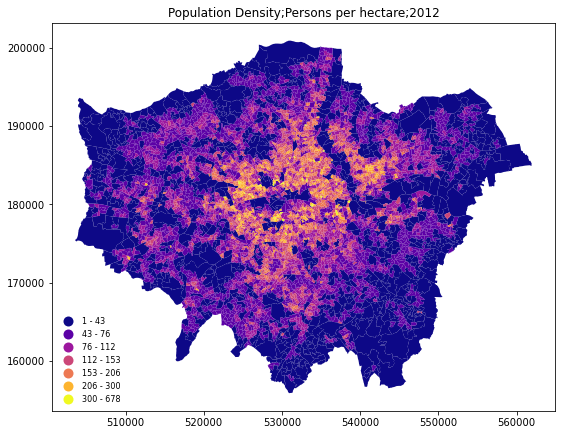

In [172]:
col = 'Population Density;Persons per hectare;2012'
fig = gdf.plot(column=col, cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', 
         legend=True, legend_kwds={'frameon':False, 'fontsize':8},
         figsize=(9,8));
plt.title(col);

# Now to modify the legend: googling "geopandas format legend"
# brings me to: https://stackoverflow.com/a/56591102/4041902
leg = fig.get_legend()
leg._loc = 3

for lbl in leg.get_texts():
    label_text = lbl.get_text()
    [low, hi] = label_text.split(', ')
    new_text = f'{float(low):,.0f} - {float(hi):,.0f}'
    lbl.set_text(new_text)

plt.show();

In [174]:
gdf.to_feather(os.path.join('data','geo','LSOA_Atlas.geofeather'))
print("Done.")

Done.


### Boundary data

In [177]:
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path
ddir  = os.path.join('data','geo') # destination directory
water = gpd.read_file(cache_data(spath+'Water.gpkg?raw=true', ddir))
boros = gpd.read_file(cache_data(spath+'Boroughs.gpkg?raw=true', ddir))
green = gpd.read_file(cache_data(spath+'Greenspace.gpkg?raw=true', ddir))

lsoas = gpd.read_feather(os.path.join('data','geo','LSOA_Atlas.geofeather'))

print("Done.")

Found data/geo/Water.gpkg locally!
Found data/geo/Boroughs.gpkg locally!
Found data/geo/Greenspace.gpkg locally!
Done.


In [178]:
lsoas.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

<AxesSubplot:>

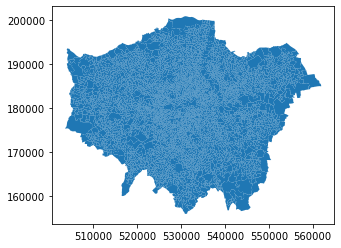

In [179]:
lsoas.plot() #to check

## Airbnb data 2016

In [209]:
# Set download URL
host   = 'https://orca.casa.ucl.ac.uk'
path16 = '~jreades/data/London-2016-02-02-listings.csv.gz'
url16  = f'{host}/{path16}'

airbnb_2016 = pd.read_csv(url16, compression='gzip', low_memory=False)
print(f"Data frame is {airbnb_2016.shape[0]:,} x {airbnb_2016.shape[1]}")


Data frame is 33,715 x 92


In [211]:
# save raw listing data locally
path = os.path.join('data','raw') 
fn16 = url16.split('/')[-1]         
print(f"Writing to: {fn16}")

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
airbnb_2016.to_csv(os.path.join(path,fn16), index=False)
print("Done.")

Writing to: London-2016-02-02-listings.csv.gz
Done.


In [212]:
print(airbnb_2016.columns.to_list())

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'gues

### Data cleaning

In [213]:
cols_2016 = ['id', 'name', 'host_id', 'host_name', 'neighbourhood_cleansed', 'latitude', 'longitude', 
 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 
 'calculated_host_listings_count', 'availability_365']

In [214]:
airbnb_2016 = pd.read_csv(os.path.join(path,fn16), 
                low_memory=False, usecols=cols_2016)
print(f"Data frame is {airbnb_2016.shape[0]:,} x {airbnb_2016.shape[1]}")

Data frame is 33,716 x 15


drop Nulls by columns

In [215]:
airbnb_2016.isnull().sum(axis=0).sort_values(ascending=False)[:12]

last_review                       9940
reviews_per_month                 9940
host_name                            6
price                                2
minimum_nights                       2
availability_365                     2
number_of_reviews                    2
calculated_host_listings_count       2
id                                   1
host_id                              1
neighbourhood_cleansed               1
latitude                             1
dtype: int64

In [217]:
airbnb_2016.drop(columns=['last_review','reviews_per_month'], inplace=True)

drop NAs and Nulls by rows

In [219]:
airbnb_2016.drop(airbnb_2016[airbnb_2016.id.isna()].index.array, axis=0, inplace=True)

In [237]:
airbnb_2016.isna().sum(axis=1).sort_values(ascending=False).head(10)

0        0
22485    0
22483    0
22482    0
22481    0
22480    0
22479    0
22478    0
22477    0
22476    0
dtype: int64

In [222]:
airbnb_2016.isnull().sum(axis=1).sort_values(ascending=False).head(10)

27684    9
23696    1
26111    1
24407    1
12962    1
20429    1
22479    0
22478    0
22477    0
22472    0
dtype: int64

In [223]:
airbnb_2016.drop(probs[probs > 0].index, inplace=True)

In [224]:
print(f"Have reduced data frame to: {airbnb_2016.shape[0]} rows and {airbnb_2016.shape[1]} columns")

Have reduced data frame to: 33709 rows and 13 columns


## Airbnb data 2019

In [225]:
# Set download URL
host   = 'https://orca.casa.ucl.ac.uk'
path19 = '~jreades/data/London-2019-11-listings.csv.gz'
url19  = f'{host}/{path19}'

airbnb_2019 = pd.read_csv(url19, compression='gzip', low_memory=False)
print(f"Data frame is {airbnb_2019.shape[0]:,} x {airbnb_2019.shape[1]}")


Data frame is 85,236 x 18


In [226]:
# save raw listing data locally
path = os.path.join('data','raw') 
fn19 = url19.split('/')[-1]         
print(f"Writing to: {fn19}")

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
airbnb_2019.to_csv(os.path.join(path,fn19), index=False)
print("Done.")

Writing to: London-2019-11-listings.csv.gz
Done.


In [227]:
print(airbnb_2019.columns.to_list())

['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'room_class', 'last_review_timestamp']


### Data cleaning

In [228]:
cols_2019 = ['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'latitude', 'longitude', 
 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 
 'calculated_host_listings_count', 'availability_365']

In [232]:
airbnb_2019 = pd.read_csv(os.path.join(path,fn19), 
                low_memory=False, usecols=cols_2019)
print(f"Data frame is {airbnb_2019.shape[0]:,} x {airbnb_2019.shape[1]}")

Data frame is 85,236 x 15


drop NAs and Nulls by columns

In [233]:
airbnb_2019.isnull().sum(axis=0).sort_values(ascending=False)[:12]

id                   0
name                 0
host_id              0
host_name            0
neighbourhood        0
latitude             0
longitude            0
room_type            0
price                0
minimum_nights       0
number_of_reviews    0
last_review          0
dtype: int64

In [238]:
airbnb_2019.isna().sum(axis=0).sort_values(ascending=False)[:12]

id                   0
name                 0
host_id              0
host_name            0
neighbourhood        0
latitude             0
longitude            0
room_type            0
price                0
minimum_nights       0
number_of_reviews    0
last_review          0
dtype: int64

drop NAs and Nulls by rows

In [234]:
airbnb_2019.drop(airbnb_2019[airbnb_2019.id.isna()].index.array, axis=0, inplace=True)

In [239]:
airbnb_2019.isna().sum(axis=1).sort_values(ascending=False).head(5)

0        0
56831    0
56829    0
56828    0
56827    0
dtype: int64

In [240]:
airbnb_2019.isnull().sum(axis=1).sort_values(ascending=False).head(5)

0        0
56831    0
56829    0
56828    0
56827    0
dtype: int64

In [236]:
print(f"Have reduced data frame to: {airbnb_2019.shape[0]} rows and {airbnb_2019.shape[1]} columns")

Have reduced data frame to: 85236 rows and 15 columns


No reduction is made.. 

## Airbnb data 2022

In [241]:
# Set download URL
host   = 'https://orca.casa.ucl.ac.uk'
path22 = '~jreades/data/2022-09-10-listings.csv.gz'
url22  = f'{host}/{path22}'

airbnb_2022 = pd.read_csv(url22, compression='gzip', low_memory=False)
print(f"Data frame is {airbnb_2022.shape[0]:,} x {airbnb_2022.shape[1]}")


Data frame is 69,351 x 75


In [242]:
# save raw listing data locally
path = os.path.join('data','raw') 
fn22 = url22.split('/')[-1]         
print(f"Writing to: {fn22}")

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
airbnb_2022.to_csv(os.path.join(path,fn22), index=False)
print("Done.")

Writing to: 2022-09-10-listings.csv.gz
Done.


In [243]:
print(airbnb_2022.columns.to_list())

['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availabil

### Data Cleaning

In [244]:
cols_2022 = ['id', 'listing_url', 'last_scraped', 'name', 'host_id', 'host_name', 'host_since', 'host_location', 
 'host_response_time', 'host_is_superhost', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 
 'neighbourhood_cleansed','latitude', 'longitude', 'room_type', 'accommodates', 'price', 'minimum_nights', 'minimum_nights_avg_ntm', 
 'calendar_updated', 'has_availability', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 
'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review']

In [245]:
airbnb_2022 = pd.read_csv(os.path.join(path,fn22), 
                low_memory=False, usecols=cols_2022)
print(f"Data frame is {airbnb_2022.shape[0]:,} x {airbnb_2022.shape[1]}")

Data frame is 69,358 x 30


drop Nulls by columns

In [248]:
airbnb_2022.isnull().sum(axis=0).sort_values(ascending=False)[:12]

calendar_updated             69353
host_response_time           26534
host_neighbourhood           25763
last_review                  16787
first_review                 16785
host_location                12371
host_is_superhost               26
name                            21
availability_365                14
host_total_listings_count       13
host_listings_count             12
minimum_nights_avg_ntm          12
dtype: int64

In [249]:
airbnb_2022.drop(columns=['calendar_updated','host_response_time','host_neighbourhood'], inplace=True)

drop Nulls by rows

In [250]:
airbnb_2022.drop(airbnb_2022[airbnb_2022.id.isna()].index.array, axis=0, inplace=True)

In [251]:
airbnb_2022.isnull().sum(axis=1).sort_values(ascending=False).head(20)

53487    19
63388    19
52563    19
66384    19
64775    19
9103     19
23112    19
4511      7
5697      7
7415      7
6959      7
6365      7
64776     6
66385     5
43619     4
42843     4
43102     4
42838     4
46090     4
43318     4
dtype: int64

<AxesSubplot:ylabel='Frequency'>

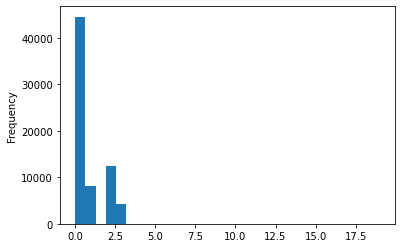

In [252]:
probs = airbnb_2022.isnull().sum(axis=1)
probs.plot.hist(bins=30)

In [253]:
airbnb_2022.drop(probs[probs > 2].index, inplace=True)

In [254]:
print(f"Have reduced data frame to: {airbnb_2022.shape[0]} rows and {airbnb_2022.shape[1]} columns")

Have reduced data frame to: 64987 rows and 27 columns


correct data type

In [255]:
airbnb_2016.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33709 entries, 0 to 33715
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              33709 non-null  float64
 1   name                            33709 non-null  object 
 2   host_id                         33709 non-null  float64
 3   host_name                       33709 non-null  object 
 4   neighbourhood_cleansed          33709 non-null  object 
 5   latitude                        33709 non-null  object 
 6   longitude                       33709 non-null  object 
 7   room_type                       33709 non-null  object 
 8   price                           33709 non-null  object 
 9   minimum_nights                  33709 non-null  float64
 10  availability_365                33709 non-null  float64
 11  number_of_reviews               33709 non-null  float64
 12  calculated_host_listings_count  

In [258]:
cats = ['neighbourhood_cleansed','room_type']
for c in cats:
    print(f"Converting {c}")
    airbnb_2016[c] = airbnb_2016[c].astype('category')

Converting neighbourhood_cleansed
Converting room_type


In [259]:
money = ['price']
for m in money:
    print(f"Converting {m}")
    airbnb_2016[m] = airbnb_2016[m].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')

Converting price


In [260]:
ints  = ['id','host_id','minimum_nights','availability_365', 'number_of_reviews', 'calculated_host_listings_count']
for i in ints:
    print(f"Converting {i}")
    try:
        airbnb_2016[i] = airbnb_2016[i].astype('float').astype('int')
    except ValueError as e:
        print("  - !!!Converting to unsigned 16-bit integer!!!")
        airbnb_2016[i] = airbnb_2016[i].astype('float').astype(pd.UInt16Dtype())

Converting id
Converting host_id
Converting minimum_nights
Converting availability_365
Converting number_of_reviews
Converting calculated_host_listings_count


In [261]:
airbnb_2016.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33709 entries, 0 to 33715
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              33709 non-null  int64   
 1   name                            33709 non-null  object  
 2   host_id                         33709 non-null  int64   
 3   host_name                       33709 non-null  object  
 4   neighbourhood_cleansed          33709 non-null  category
 5   latitude                        33709 non-null  object  
 6   longitude                       33709 non-null  object  
 7   room_type                       33709 non-null  category
 8   price                           33709 non-null  float64 
 9   minimum_nights                  33709 non-null  int64   
 10  availability_365                33709 non-null  int64   
 11  number_of_reviews               33709 non-null  int64   
 12  calculated_host_li

In [256]:
airbnb_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85236 entries, 0 to 85235
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              85236 non-null  object
 1   name                            85236 non-null  object
 2   host_id                         85236 non-null  object
 3   host_name                       85236 non-null  object
 4   neighbourhood                   85236 non-null  object
 5   latitude                        85236 non-null  object
 6   longitude                       85236 non-null  object
 7   room_type                       85236 non-null  object
 8   price                           85236 non-null  object
 9   minimum_nights                  85236 non-null  object
 10  number_of_reviews               85236 non-null  object
 11  last_review                     85236 non-null  object
 12  reviews_per_month               85236 non-null

In [262]:
dates = ['last_review']
for d in dates:
    print("Converting " + d)
    airbnb_2019 = airbnb_2019[airbnb_2019[d].str.match(r'\d{4}-\d{2}-\d{2}', na=True)] # Drop some non-date values
    airbnb_2019[d] = pd.to_datetime(airbnb_2019[d], infer_datetime_format=True)

Converting last_review


In [263]:
cats = ['neighbourhood','room_type']
for c in cats:
    print(f"Converting {c}")
    airbnb_2019[c] = airbnb_2019[c].astype('category')

Converting neighbourhood
Converting room_type


In [266]:
money = ['price']
for m in money:
    print(f"Converting {m}")
    airbnb_2019[m] = airbnb_2019[m].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')

Converting price


In [264]:
ints  = ['id','host_id','minimum_nights','availability_365', 'number_of_reviews', 'reviews_per_month','calculated_host_listings_count']
for i in ints:
    print(f"Converting {i}")
    try:
        airbnb_2019[i] = airbnb_2019[i].astype('float').astype('int')
    except ValueError as e:
        print("  - !!!Converting to unsigned 16-bit integer!!!")
        airbnb_2019[i] = airbnb_2019[i].astype('float').astype(pd.UInt16Dtype())

Converting id
Converting host_id
Converting minimum_nights
Converting availability_365
Converting number_of_reviews
Converting reviews_per_month
Converting calculated_host_listings_count


In [267]:
airbnb_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64938 entries, 0 to 64937
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              64938 non-null  int64         
 1   name                            64938 non-null  object        
 2   host_id                         64938 non-null  int64         
 3   host_name                       64938 non-null  object        
 4   neighbourhood                   64938 non-null  category      
 5   latitude                        64938 non-null  object        
 6   longitude                       64938 non-null  object        
 7   room_type                       64938 non-null  category      
 8   price                           64938 non-null  float64       
 9   minimum_nights                  64938 non-null  int64         
 10  number_of_reviews               64938 non-null  int64         
 11  la

In [257]:
airbnb_2022.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64987 entries, 0 to 69357
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         64987 non-null  object 
 1   listing_url                64987 non-null  object 
 2   last_scraped               64987 non-null  object 
 3   name                       64980 non-null  object 
 4   host_id                    64987 non-null  float64
 5   host_name                  64987 non-null  object 
 6   host_since                 64987 non-null  object 
 7   host_location              56959 non-null  object 
 8   host_is_superhost          64980 non-null  object 
 9   host_listings_count        64987 non-null  object 
 10  host_total_listings_count  64987 non-null  float64
 11  neighbourhood_cleansed     64987 non-null  object 
 12  latitude                   64987 non-null  float64
 13  longitude                  64987 non-null  flo

In [287]:
bools = ['host_is_superhost','has_availability']
for b in bools:
    print(f"Converting {b}")
    airbnb_2022[b] = airbnb_2022[b].replace({'f':False, 't':True}).astype('bool')

Converting host_is_superhost
Converting has_availability


In [268]:
dates = ['last_scraped','host_since','calendar_last_scraped','first_review','last_review']
for d in dates:
    print("Converting " + d)
    airbnb_2022 = airbnb_2022[airbnb_2022[d].str.match(r'\d{4}-\d{2}-\d{2}', na=True)] # Drop some non-date values
    airbnb_2022[d] = pd.to_datetime(airbnb_2022[d], infer_datetime_format=True)

Converting last_scraped
Converting host_since
Converting calendar_last_scraped
Converting first_review
Converting last_review


In [269]:
cats = ['neighbourhood_cleansed','room_type']
for c in cats:
    print(f"Converting {c}")
    airbnb_2022[c] = airbnb_2022[c].astype('category')

Converting neighbourhood_cleansed
Converting room_type


In [270]:
money = ['price']
for m in money:
    print(f"Converting {m}")
    airbnb_2022[m] = airbnb_2022[m].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')

Converting price


In [275]:
ints  = ['id','host_id','host_listings_count','host_total_listings_count','accommodates', 'minimum_nights',
         'availability_365', 'number_of_reviews']
for i in ints:
    print(f"Converting {i}")
    try:
        airbnb_2022[i] = airbnb_2022[i].astype('float').astype('int')
    except ValueError as e:
        print("  - !!!Converting to unsigned 16-bit integer!!!")
        airbnb_2022[i] = airbnb_2022[i].astype('float').astype(pd.UInt16Dtype())

Converting id
Converting host_id
Converting host_listings_count
Converting host_total_listings_count
Converting accommodates
Converting minimum_nights
Converting availability_365
Converting number_of_reviews


In [276]:
airbnb_2022.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64986 entries, 0 to 69357
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         64986 non-null  int64         
 1   listing_url                64986 non-null  object        
 2   last_scraped               64986 non-null  datetime64[ns]
 3   name                       64979 non-null  object        
 4   host_id                    64986 non-null  int64         
 5   host_name                  64986 non-null  object        
 6   host_since                 64986 non-null  datetime64[ns]
 7   host_location              56958 non-null  object        
 8   host_is_superhost          64979 non-null  object        
 9   host_listings_count        64986 non-null  int64         
 10  host_total_listings_count  64986 non-null  int64         
 11  neighbourhood_cleansed     64986 non-null  category      
 12  lati

save the cleaned listing file locally 

In [278]:
path = os.path.join('data','clean')

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
airbnb_2016.to_csv(os.path.join(path,fn16), index=False)
airbnb_2019.to_csv(os.path.join(path,fn19), index=False)
airbnb_2022.to_csv(os.path.join(path,fn22), index=False)

print("Done.")

Done.


In [279]:
airbnb_2016.reset_index().to_feather(os.path.join(path,fn16.replace('.csv.gz','.feather')))
airbnb_2019.reset_index().to_feather(os.path.join(path,fn19.replace('.csv.gz','.feather')))
airbnb_2022.reset_index().to_feather(os.path.join(path,fn22.replace('.csv.gz','.feather')))

In [280]:
airbnb_2016_feather = pd.read_feather(os.path.join(path,fn16.replace('.csv.gz','.feather')))
print(f"2016 Data frame is {airbnb_2016_feather.shape[0]:,} x {airbnb_2016_feather.shape[1]}")
airbnb_2019_feather = pd.read_feather(os.path.join(path,fn19.replace('.csv.gz','.feather')))
print(f"2019 Data frame is {airbnb_2019_feather.shape[0]:,} x {airbnb_2019_feather.shape[1]}")
airbnb_2022_feather = pd.read_feather(os.path.join(path,fn22.replace('.csv.gz','.feather')))
print(f"2022 Data frame is {airbnb_2022_feather.shape[0]:,} x {airbnb_2022_feather.shape[1]}")


2016 Data frame is 33,709 x 14
2019 Data frame is 64,938 x 16
2022 Data frame is 64,986 x 28


lat/long to geoseries

In [281]:
gdf2016 = gpd.GeoDataFrame(airbnb_2016_feather, 
      geometry=gpd.points_from_xy(airbnb_2016_feather.longitude, airbnb_2016_feather.latitude, crs='epsg:4326'))
gdf2019 = gpd.GeoDataFrame(airbnb_2019_feather, 
      geometry=gpd.points_from_xy(airbnb_2019_feather.longitude, airbnb_2019_feather.latitude, crs='epsg:4326'))
gdf2022 = gpd.GeoDataFrame(airbnb_2022_feather, 
      geometry=gpd.points_from_xy(airbnb_2022_feather.longitude, airbnb_2022_feather.latitude, crs='epsg:4326'))

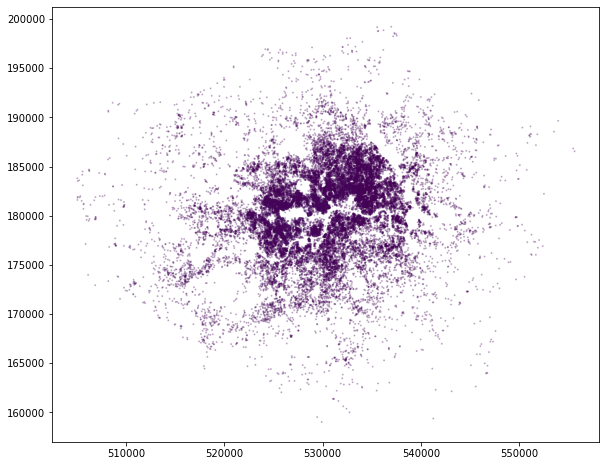

In [282]:
gdf2016.to_crs('epsg:27700').plot(column='price', cmap='viridis', alpha=0.25, markersize=1, figsize=(12,8));

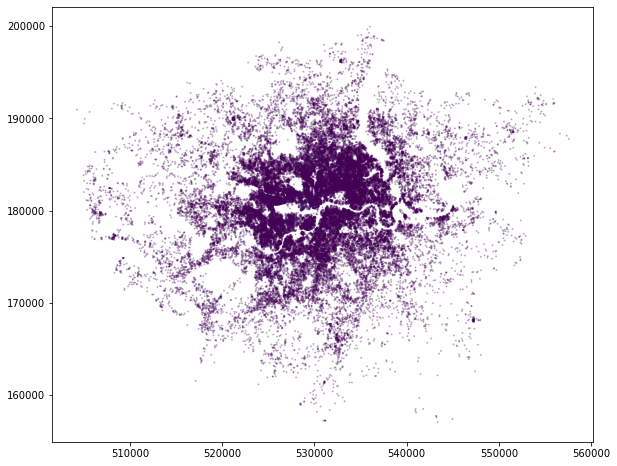

In [283]:
gdf2019.to_crs('epsg:27700').plot(column='price', cmap='viridis', alpha=0.25, markersize=1, figsize=(12,8));

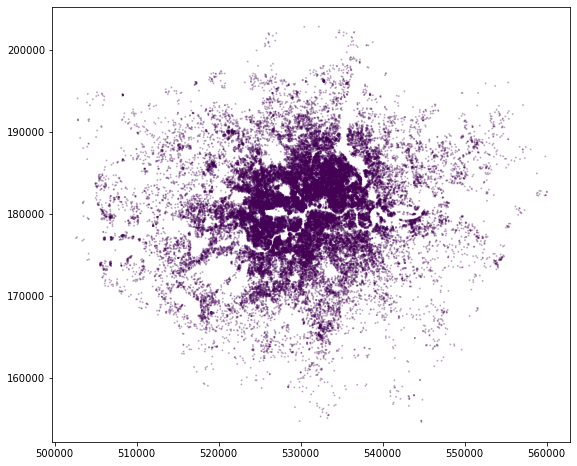

In [284]:
gdf2022.to_crs('epsg:27700').plot(column='price', cmap='viridis', alpha=0.25, markersize=1, figsize=(12,8));

In [285]:
print(f"Using '{fn16.replace('.csv.gz','.feather')}' as basis for saving data...")
gdf2016.to_feather(os.path.join('data','geo',fn16.replace('.feather','.geofeather')))
print(f"Using '{fn19.replace('.csv.gz','.feather')}' as basis for saving data...")
gdf2019.to_feather(os.path.join('data','geo',fn19.replace('.feather','.geofeather')))
print(f"Using '{fn22.replace('.csv.gz','.feather')}' as basis for saving data...")
gdf2022.to_feather(os.path.join('data','geo',fn22.replace('.feather','.geofeather')))

Using 'London-2016-02-02-listings.feather' as basis for saving data...
Using 'London-2019-11-listings.feather' as basis for saving data...
Using '2022-09-10-listings.feather' as basis for saving data...


### Join listing to boundary

In [286]:
listings16 = gpd.read_feather(os.path.join('data','geo',fn16.replace('.feather','.geofeather'))).to_crs(epsg=27700).drop(columns=['index']).set_index('id')
print(f"2016 Data frame is {listings16.shape[0]:,} x {listings16.shape[1]}")
listings19 = gpd.read_feather(os.path.join('data','geo',fn19.replace('.feather','.geofeather'))).to_crs(epsg=27700).drop(columns=['index']).set_index('id')
print(f"2019 Data frame is {listings19.shape[0]:,} x {listings19.shape[1]}")
listings22 = gpd.read_feather(os.path.join('data','geo',fn22.replace('.feather','.geofeather'))).to_crs(epsg=27700).drop(columns=['index']).set_index('id')
print(f"2022 Data frame is {listings22.shape[0]:,} x {listings22.shape[1]}")

2016 Data frame is 33,709 x 13
2019 Data frame is 64,938 x 15
2022 Data frame is 64,986 x 27


In [287]:
lsoa_listings16 = gpd.sjoin(listings16, lsoas)
lsoa_listings19 = gpd.sjoin(listings19, lsoas)
lsoa_listings22 = gpd.sjoin(listings22, lsoas)

In [184]:
lsoa_listings22.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 68527 entries, 13913 to 54085211
Columns: 107 entries, listing_url to Subregion
dtypes: bool(2), category(2), datetime64[ns](4), float32(6), float64(74), geometry(1), int64(7), object(11)
memory usage: 53.1+ MB


In [185]:
lsoa_listings22.last_review.head(10)

id
13913      2022-07-15
89870      2022-08-28
3756649    2019-08-17
4658706    2017-08-14
4963378    2018-09-23
6519252           NaT
8732941    2015-12-07
9671824           NaT
13321242   2017-08-25
15697845   2022-09-06
Name: last_review, dtype: datetime64[ns]

select the recently reviewed listings in 2022

In [186]:
lsoa_listings_2022 = lsoa_listings22[lsoa_listings22['last_review'].dt.strftime('%Y') == '2022']

In [187]:
lsoa_listings_2022.last_review.count()

29416

This reduces the number of listings to 29416 from around 68527. Hence, around half of the listings are not active recently. 

# Descriptive summary 

# The Occupancy Model

Estimated booking per listing = number of review * 2

Occupancy (number of night booked) = Average length of stay * estimated booking per listing per year

The number of review is total throughout the lifetime of each listing. This is less useful for comparison as listings have different start and end dates on Airbnb. Since our analysis is based on 2022, it is more reasonable to use number of reviews in the last 30 days or last 12 months for analysis.  

It is found that the average length of stay for oversea tourists in London in 2019 is 5.47 nights. 
This group is the potential target renters for Airbnb. 
However, the data is in 2019, which could be influenced by the pandemic. It would be more accurate to obtain data from 2022. 
source: https://www.statista.com/statistics/487772/average-length-overseas-visits-by-purpose-london-uk/

However, it is also suggested that when the number of minimum nights bookable is larger than the average length of stay, the minimum nights would be used for calculation. 

Thus, occupancy could be calculated as

5.47 * (number of reviews in last 12 months) * 2

or

(minimum nights) * (number of reviews in last 12 months) * 2

In [326]:
msoa_listings_2022['averstay'] = np.where(msoa_listings_2022['minimum_nights']>5.47, msoa_listings_2022['minimum_nights'], 5.47)

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [318]:
msoa_listings_2022['occupancy'] = msoa_listings_2022['averstay'] * msoa_listings_2022['number_of_reviews_ltm'] *2

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [319]:
msoa_listings_2022.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 29342 entries, 13913 to 663811353105819136
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   listing_url                29342 non-null  object        
 1   last_scraped               29342 non-null  datetime64[ns]
 2   name                       29342 non-null  object        
 3   host_id                    29342 non-null  int64         
 4   host_name                  29342 non-null  object        
 5   host_since                 29342 non-null  datetime64[ns]
 6   host_location              23806 non-null  object        
 7   host_is_superhost          29342 non-null  bool          
 8   host_neighbourhood         17315 non-null  object        
 9   host_listings_count        29342 non-null  int64         
 10  host_total_listings_count  29342 non-null  int64         
 11  neighbourhood_cleansed     29342 non-null 

In [121]:
msoa_listings_2022 = msoa_listings_2022.drop(columns = {'averstay'}, axis = 1)

In [320]:
msoa_listings_2022.averstay.head(10)

id
13913      5.47
89870      5.47
993428     5.47
1211331    5.47
1458193    5.47
13809624   5.47
15523209   5.47
15697845   5.47
18893833   5.47
21063433   5.47
Name: averstay, dtype: float64

In [321]:
msoa_listings_2022.occupancy.head(10)

id
13913       98.46
89870      262.56
993428     185.98
1211331     43.76
1458193     10.94
13809624   153.16
15523209   590.76
15697845   371.96
18893833    32.82
21063433   634.52
Name: occupancy, dtype: float64

In [322]:
msoa_listings_2022.minimum_nights.head(10)

id
13913       1
89870       1
993428      1
1211331     2
1458193     2
13809624    2
15523209    2
15697845    2
18893833    3
21063433    1
Name: minimum_nights, dtype: int64

In [354]:
msoa_listings_2022.number_of_reviews_ltm.head(10)

id
13913       9.00
89870      24.00
993428     17.00
1211331     4.00
1458193     1.00
13809624   14.00
15523209   54.00
15697845   34.00
18893833    3.00
21063433   58.00
Name: number_of_reviews_ltm, dtype: float64

In [353]:
msoa_listings_2022.availability_365.head(10)

id
13913      343.00
89870      343.00
993428     221.00
1211331    314.00
1458193     59.00
13809624   321.00
15523209    41.00
15697845   322.00
18893833     0.00
21063433   315.00
Name: availability_365, dtype: float64

In [352]:
msoa_listings_2022.availability_365.describe()

count   29,342.00
mean       158.36
std        129.78
min          0.00
25%         32.00
50%        135.00
75%        293.00
max        365.00
Name: availability_365, dtype: float64

<AxesSubplot:ylabel='Frequency'>

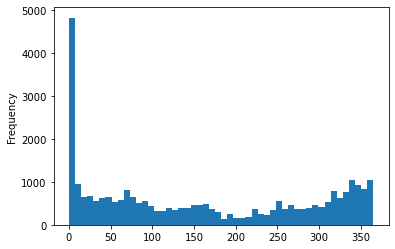

In [327]:
msoa_listings_2022.availability_365.plot.hist(bins=50) # histogram

In [328]:
msoa_listings_2022.occupancy.describe()

count   29,342.00
mean       135.11
std        262.70
min         10.94
25%         32.82
50%         76.58
75%        153.16
max     13,870.00
Name: occupancy, dtype: float64

<AxesSubplot:ylabel='Frequency'>

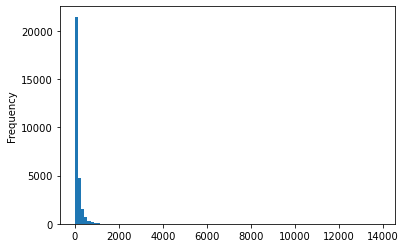

In [329]:
msoa_listings_2022.occupancy.plot.hist(bins=100) # histogram

In [330]:
msoa_listings_2022.sort_values(by = 'occupancy',ascending=False).head(20)[['name','price','minimum_nights','minimum_nights_avg_ntm','number_of_reviews_ltm','occupancy']]

,name,price,minimum_nights,minimum_nights_avg_ntm,number_of_reviews_ltm,occupancy
id,,,,,,
45373006,DOUBLE STUDIO @ CRAVEN HILL GARDENS,159.00,365,148.40,19.00,"13,870.00"
24020480,Double room with The Shard view in Kennington SE5,29.00,360,360.00,18.00,"12,960.00"
46810060,DOUBLE ROOM @ CRAVEN HILL GARDENS,145.00,365,148.40,14.00,"10,220.00"
7742194,Cosy Double studio in Zone 2 Hammersmith (8),45.00,170,8.60,24.00,"8,160.00"
47408549,Double Room+ Ensuite,167.00,1,1.00,660.00,"7,220.40"
30760930,Double Garden View room - London House Hotel***,343.00,1,1.10,631.00,"6,903.14"
43120947,Private double room with en suite facilities,110.00,1,1.00,615.00,"6,728.10"
24507428,Jack's place - Luxury Industrial style 1 bed flat,128.00,90,90.00,36.00,"6,480.00"
4594609,£100 for entire 2 bed flat in trendy east London!,74.00,120,120.00,27.00,"6,480.00"


The extremely high occupancy above 365 nights per year indicates errors in the estimation method. 
When comparing columns minimum_nights and minimum_nights_avg_ntm, it is found  that the later could be more accurate in representing the shortest booking length, which might vary during the year controlled by the owners. 

In [331]:
msoa_listings_2022['averstay2'] = np.where(msoa_listings_2022['minimum_nights_avg_ntm']>5.47, msoa_listings_2022['minimum_nights_avg_ntm'], 5.47)

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [332]:
msoa_listings_2022['occupancy2'] = msoa_listings_2022['averstay2'] * msoa_listings_2022['number_of_reviews_ltm'] *2

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [333]:
msoa_listings_2022.occupancy2.describe()

count   29,342.00
mean       179.11
std        521.46
min         10.94
25%         32.82
50%         76.58
75%        182.00
max     66,864.80
Name: occupancy2, dtype: float64

In [358]:
msoa_listings_2022.sort_values(by = 'occupancy2',ascending=False).head(20)[['name','price','minimum_nights_avg_ntm','number_of_reviews_ltm','occupancy2']]

,name,price,minimum_nights_avg_ntm,number_of_reviews_ltm,occupancy2
id,,,,,
19962547,Stunning & Modern 3-Bed Home In Victoria,591.00,879.80,38.00,"66,864.80"
24020480,Double room with The Shard view in Kennington SE5,29.00,360.00,18.00,"12,960.00"
52804602,"Chinatown-Soho-Piccadilly, Two Bedroom Flat for 4",499.00,170.00,36.00,"12,240.00"
52954343,Marylebone Mews - Beautiful 2 bedroom flat,243.00,90.00,65.00,"11,700.00"
27960111,"Great Location, Bright & Clean, Covent Garden ...",425.00,155.00,26.00,"8,060.00"
47408549,Double Room+ Ensuite,167.00,1.00,660.00,"7,220.40"
30760930,Double Garden View room - London House Hotel***,343.00,1.10,631.00,"6,903.14"
43120947,Private double room with en suite facilities,110.00,1.00,615.00,"6,728.10"
4594609,£100 for entire 2 bed flat in trendy east London!,74.00,120.00,27.00,"6,480.00"


There are still some high values. The minimum length of stay higher than 90 nights may breach the short-term rental regulation. 

Listings that are highly occupied (occupancy>365) could be owing to high review rate or high minimum nights. Those that are frequently reviewed and obtaining high minimun nights might be less possible. Some high minimum nights might be typo from the host. Others might be that the host would like to increase the exposure of their listings but not renting them out on Airbnb platfrom, but on their own website, so the hosts set the minimum nights on purpose. Apart from those, listing with high minimum nights may breach the regulation of STR minimum night of 90 nights. Thus, those listings may bias the analysis on occupancy and they'll be removed from the dataset. However, analysis from other scopes like STR regulations on minimum nights could use the data. 

In [355]:
to_drop = msoa_listings_2022[(msoa_listings_2022.minimum_nights_avg_ntm > 90) | 
            (msoa_listings_2022.minimum_nights_avg_ntm*msoa_listings_2022.number_of_reviews_ltm > 365)]
to_drop.occupancy3.count()


1005

In [357]:
msoa_listings_2022[(msoa_listings_2022.occupancy2 > 365)].occupancy2.count()

3367

In [360]:
to_drop.head(10)[['number_of_reviews_ltm','averstay2','occupancy2','minimum_nights_avg_ntm']]

,number_of_reviews_ltm,averstay2,occupancy2,minimum_nights_avg_ntm
id,,,,
17329226,23.00,29.20,"1,343.20",29.20
53356158,18.00,29.00,"1,044.00",29.00
521982,19.00,28.50,"1,083.00",28.50
7771180,14.00,30.50,854.00,30.50
22175503,28.00,27.80,"1,556.80",27.80
44458852,18.00,27.80,"1,000.80",27.80
434962,27.00,30.60,"1,652.40",30.60
5988788,21.00,96.80,"4,065.60",96.80
7527534,26.00,75.30,"3,915.60",75.30


1005 out of 3367 are most unlikely cases. 

In [361]:
def plt_ldn(w, b):
    """
    Creates a new figure of a standard size with the 
    water (w) and boundary (b) layers set up for easy
    plotting. Right now this function assumes that you're
    looking at London, but you could parameterise it in
    other ways ot allow it to work for other areas.
    
    w: a water layer for London
    b: a borough (or other) boundary layer for London
    """
    fig, ax = plt.subplots(1, figsize=(14, 12))
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

<AxesSubplot:>

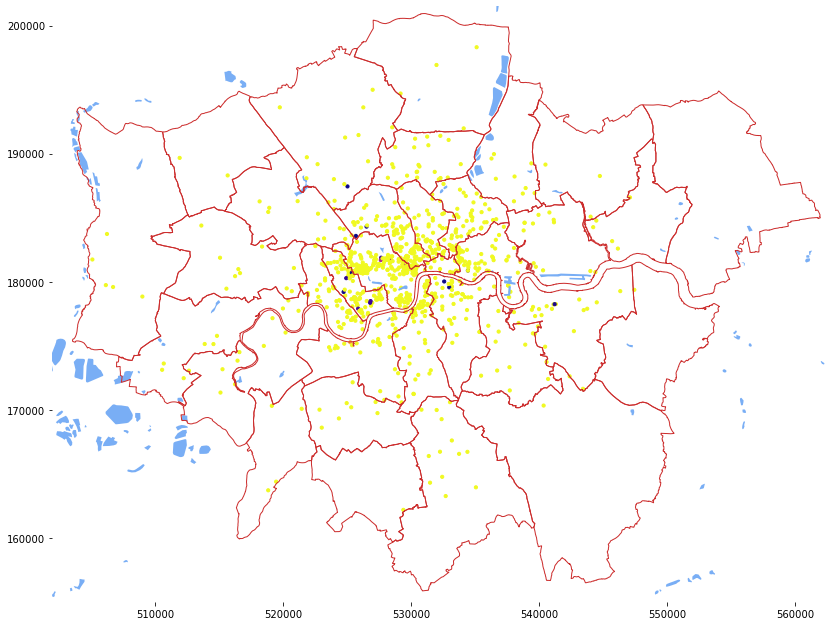

In [362]:
f,ax = plt_ldn(water, boros)
to_drop.plot(column='occupancy3', markersize=10, alpha=1, cmap='plasma', ax=ax)

For occupancy over 365, occupancy would be set as 365, which is the maximum reasonable value per year. 

In [363]:
msoa_listings_2022_cleaned = msoa_listings_2022.drop(index=to_drop.index)
print(f"Cleaned data has {msoa_listings_2022_cleaned.shape[0]:,} rows.")

Cleaned data has 28,337 rows.


In [366]:
msoa_listings_2022_cleaned['occupancy3'] = np.where(msoa_listings_2022_cleaned['occupancy2']>365, 365, msoa_listings_2022_cleaned['occupancy2'])
msoa_listings_2022_cleaned.occupancy3.describe()


count   28,337.00
mean       116.02
std        110.28
min         10.94
25%         32.82
50%         76.58
75%        164.10
max        365.00
Name: occupancy3, dtype: float64

<AxesSubplot:ylabel='Frequency'>

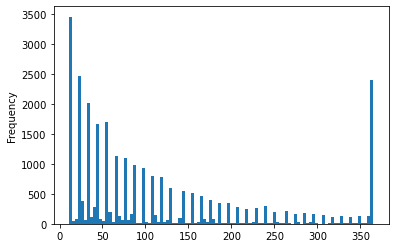

In [365]:
msoa_listings_2022_cleaned.occupancy3.plot.hist(bins=100) # histogram

### Note: this result above is different from the result on the Inside Airbnb website. Too many listings that are fully occupied..

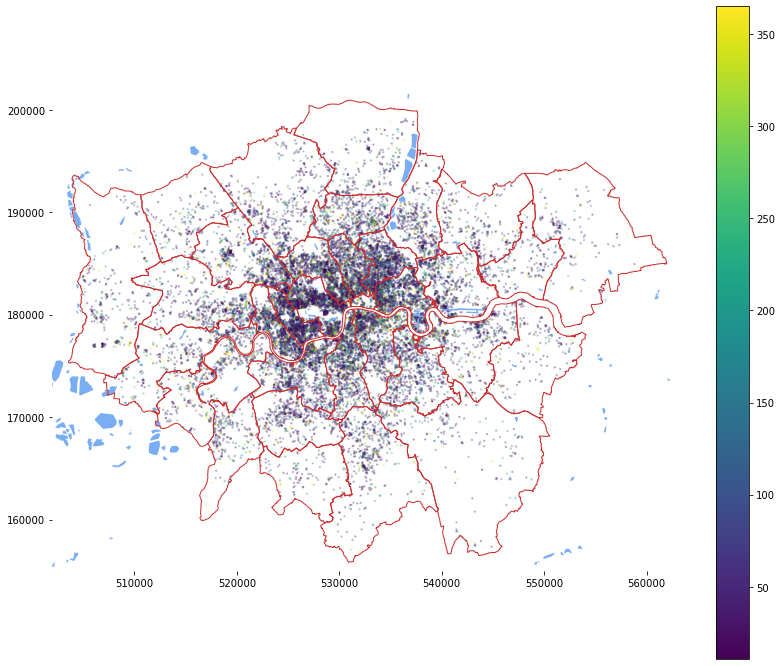

In [367]:
f,ax = plt_ldn(water, boros)
msoa_listings_2022_cleaned.plot(column='occupancy3', cmap='viridis', alpha=0.25, markersize=2, figsize=(12,8),legend=True,ax=ax);

In [368]:
msoa_listings_2022_cleaned.describe()[['occupancy3','availability_365']]

,occupancy3,availability_365
count,"28,337.00","28,337.00"
mean,116.02,157.75
std,110.28,130.03
min,10.94,0.00
25%,32.82,31.00
50%,76.58,134.00
75%,164.10,293.00
max,365.00,365.00


since the result is highly skewed. Median would be used to determine high and low values.  The availability of the lisitng in the future 365 days as per the calender. The listing may be not available because it is booked by a guest or blocked by the host. The higher the Occupancy and the higher the availability, the higher the intensity of renting activity. But it is also possible that the availability is underestimated since the guests may pre-booked thier stay. 

In [375]:
occumid = msoa_listings_2022_cleaned.occupancy3.median()
availmid = msoa_listings_2022_cleaned.availability_365.median()
msoa_listings_HH = msoa_listings_2022_cleaned[(msoa_listings_2022_cleaned.occupancy3 >= occumid) & (msoa_listings_2022_cleaned.availability_365 >= availmid)]

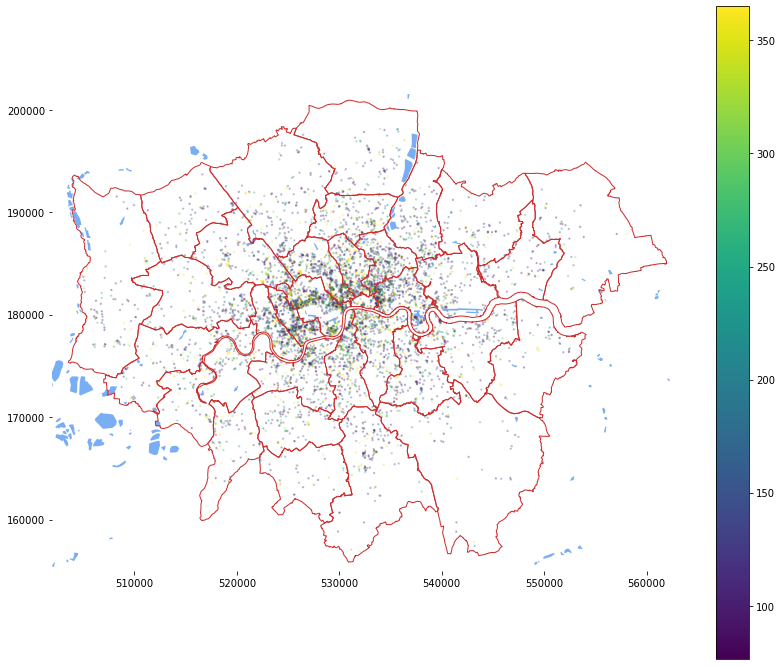

In [376]:
f,ax = plt_ldn(water, boros)
msoa_listings_HH.plot(column='occupancy3', cmap='viridis', alpha=0.25, markersize=2, figsize=(12,8),legend=True,ax=ax);

In [377]:
msoa_listings_2022_cleaned['quar'] = np.where((msoa_listings_2022_cleaned.occupancy3 >= occumid) & (msoa_listings_2022_cleaned.availability_365 >= availmid), 'HH',
                                             (np.where((msoa_listings_2022_cleaned.occupancy3 >= occumid) & (msoa_listings_2022_cleaned.availability_365 < availmid), 'HL',
                                             (np.where((msoa_listings_2022_cleaned.occupancy3 < occumid) & (msoa_listings_2022_cleaned.availability_365 < availmid), 'LL', 
                                                     'LH')))))

In [378]:
msoa_listings_2022_cleaned.head(10)[['quar','occupancy3','availability_365']]

,quar,occupancy3,availability_365
id,,,
13913,HH,98.46,343.00
89870,HH,262.56,343.00
993428,HH,185.98,221.00
1211331,LH,43.76,314.00
1458193,LL,10.94,59.00
13809624,HH,153.16,321.00
15523209,HL,365.00,41.00
15697845,HH,365.00,322.00
18893833,LL,32.82,0.00


In [379]:
cats2 = ['quar']
for c in cats2:
    print(f"Converting {c}")
    msoa_listings_2022_cleaned[c] = msoa_listings_2022_cleaned[c].astype('category')

Converting quar


In [380]:
print(msoa_listings_2022_cleaned[cats2[0]].cat.categories.values)

['HH' 'HL' 'LH' 'LL']


group by lsoas

In [381]:
test = msoa_listings_2022_cleaned.groupby(
                ['MSOA11CD']).listing_url.agg(Count='count')
test.head(3)

,Count
MSOA11CD,
E02000001,210
E02000002,2
E02000003,6


In [382]:
pivot = msoa_listings_2022_cleaned.groupby(
                ['MSOA11CD','quar']
        ).listing_url.agg(Count='count').reset_index().pivot(
                index='MSOA11CD', columns=['quar'], values=['Count'])
pivot.head(3)

Count            
quar         HH  HL  LH  LL
MSOA11CD                   
E02000001   104  36  46  24
E02000002     1   0   1   0
E02000003     1   1   4   0

In [383]:
pivot.sum()

       quar
Count  HH      7244
       HL      7134
       LH      6937
       LL      7022
dtype: int64

In [384]:
print(msoa_listings_2022_cleaned[msoa_listings_2022_cleaned.quar=='HH'].listing_url.count()) # to check 

7244


In [385]:
pivot.columns = ['HH','HL','LH','LL']

In [386]:
quar = pd.merge(lsoas.set_index('MSOA11CD'), pivot, left_index=True, right_index=True)

In [387]:
quar.head()

,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,HH,HL,LH,LL
MSOA11CD,,,,,,,,,,,,,,,,
E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.50,4385,1.60,"MULTIPOLYGON (((531667.624 180534.992, 531647....",104,36,46,24
E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.30,2713,2.50,"MULTIPOLYGON (((548881.563 190845.265, 548881....",1,0,1,0
E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,46.90,3834,2.60,"MULTIPOLYGON (((549102.438 189324.625, 548954....",1,1,4,0
E02000004,Barking and Dagenham 003,E09000002,Barking and Dagenham,E12000007,London,6182,5937,245,24.80,2318,2.60,"MULTIPOLYGON (((551549.998 187364.637, 551478....",2,0,1,0
E02000005,Barking and Dagenham 004,E09000002,Barking and Dagenham,E12000007,London,8562,8562,0,72.10,3183,2.70,"MULTIPOLYGON (((549099.634 187656.076, 549161....",3,0,3,1


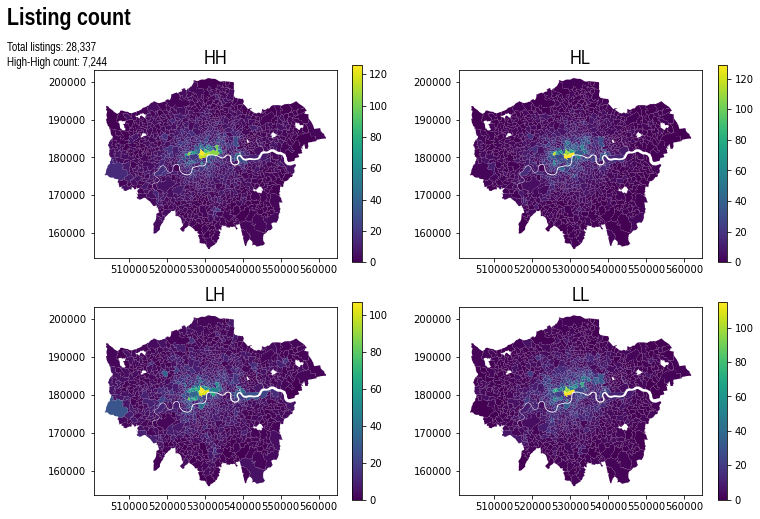

In [400]:
f,axes = plt.subplots(2,2,figsize=(12,8))

quar.plot(column='HH', ax=axes[0,0], legend=True, cmap='viridis')
axes[0,0].set_title('HH', size=20, **afont)

quar.plot(column='HL', ax=axes[0,1], legend=True, cmap='viridis')
axes[0,1].set_title('HL', size=20, **afont)

quar.plot(column='LH', ax=axes[1,0], legend=True, cmap='viridis')
axes[1,0].set_title('LH', size=20, **afont)

quar.plot(column='LL', ax=axes[1,1], legend=True, cmap='viridis')
axes[1,1].set_title('LL', size=20, **afont)

f.suptitle('Listing count', x=0.025, ha='left', size=24, **tfont)

plt.figtext(x=0.025, y=0.92, linespacing=1.4, va='top', size=12, 
            s=f"Total listings: {test['Count'].sum():,.0f}\nHigh-High count: {quar['HH'].sum():,.0f}", **bfont);

Text(0.025, 0.98, 'Usual residents per MSOAs')

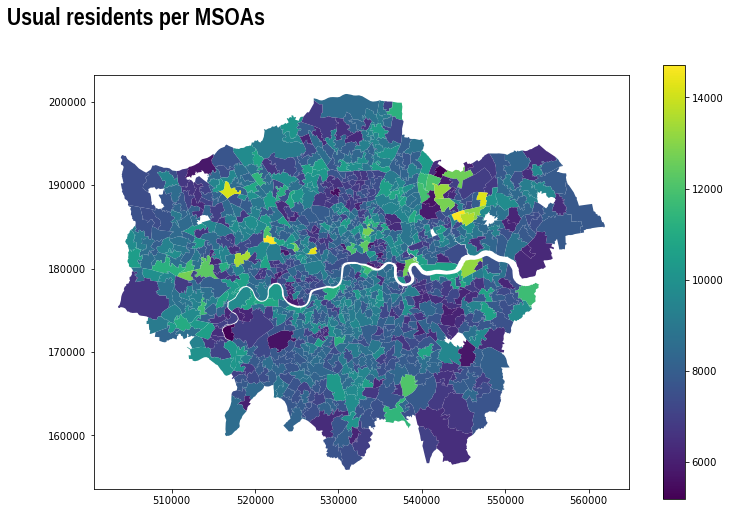

In [420]:
f,ax = plt.subplots(1,1,figsize=(12,8))

quar.plot(column='USUALRES', ax=ax, legend=True, cmap='viridis')
f.suptitle('Usual residents per LSOAs', x=0.025, ha='left', size=24, **tfont)


This result shows large range of the listing count but LSOAs with the high counts are rare as the purple colour has high coverage. High counts concentrate around inner London, where the number of usual residents is slightly lower. 

In [390]:
pts  = PowerTransformer()

pivot_norm = pd.DataFrame(index=pivot.index)
for c in pivot.columns.to_list():
    pivot_norm[c] = pts.fit_transform(pivot[c].to_numpy().reshape(-1,1))#power transform

pivot_norm.head()

,HH,HL,LH,LL
MSOA11CD,,,,
E02000001,2.81,1.79,2.27,1.53
E02000002,-0.98,-1.56,-1.09,-1.54
E02000003,-0.98,-0.77,-0.02,-1.54
E02000004,-0.53,-1.56,-1.09,-1.54
E02000005,-0.22,-1.56,-0.28,-0.81


In [391]:
quar_norm = pd.merge(lsoas.set_index('MSOA11CD'), pivot_norm, left_index=True, right_index=True)

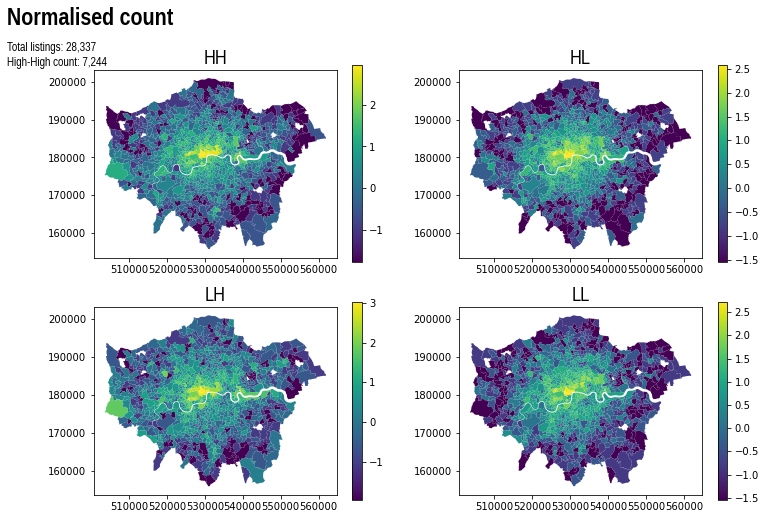

In [402]:
f,axes = plt.subplots(2,2,figsize=(12,8))

quar_norm.plot(column='HH', ax=axes[0,0], legend=True, cmap='viridis')
axes[0,0].set_title('HH', size=20, **afont)

quar_norm.plot(column='HL', ax=axes[0,1], legend=True, cmap='viridis')
axes[0,1].set_title('HL', size=20, **afont)

quar_norm.plot(column='LH', ax=axes[1,0], legend=True, cmap='viridis')
axes[1,0].set_title('LH', size=20, **afont)

quar_norm.plot(column='LL', ax=axes[1,1], legend=True, cmap='viridis')
axes[1,1].set_title('LL', size=20, **afont)

f.suptitle('Normalised count', x=0.025, ha='left', size=24, **tfont)

plt.figtext(x=0.025, y=0.92, linespacing=1.4, va='top', size=12, 
            s=f"Total listings: {test['Count'].sum():,.0f}\nHigh-High count: {quar['HH'].sum():,.0f}", **bfont);

From the outputs, the high occupancy and high availability listings are concentrated in inner London LSOAs, where the total listings are high overall. 

In [405]:
print(quar.columns.to_list())

['MSOA11NM', 'LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ', 'geometry', 'HH', 'HL', 'LH', 'LL']


In [409]:
quar_density = quar.drop(columns = ['LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ'], axis =1)

In [411]:
quar_density['count'] = quar_density.loc[:,['HH','HL','LH','LL']].sum(axis=1)
quar_density.head()

,MSOA11NM,USUALRES,geometry,HH,HL,LH,LL,count
MSOA11CD,,,,,,,,
E02000001,City of London 001,7375,"MULTIPOLYGON (((531667.624 180534.992, 531647....",104,36,46,24,210
E02000002,Barking and Dagenham 001,6775,"MULTIPOLYGON (((548881.563 190845.265, 548881....",1,0,1,0,2
E02000003,Barking and Dagenham 002,10045,"MULTIPOLYGON (((549102.438 189324.625, 548954....",1,1,4,0,6
E02000004,Barking and Dagenham 003,6182,"MULTIPOLYGON (((551549.998 187364.637, 551478....",2,0,1,0,3
E02000005,Barking and Dagenham 004,8562,"MULTIPOLYGON (((549099.634 187656.076, 549161....",3,0,3,1,7


In [414]:
quar_density['HHper'] = quar_density['HH'] / quar_density['count']
quar_density['HLper'] = quar_density['HL'] / quar_density['count']
quar_density['LHper'] = quar_density['LH'] / quar_density['count']
quar_density['LLper'] = quar_density['LL'] / quar_density['count']

quar_density.head()

,MSOA11NM,USUALRES,geometry,HH,HL,LH,LL,count,HHper,HLper,LHper,LLper
MSOA11CD,,,,,,,,,,,,
E02000001,City of London 001,7375,"MULTIPOLYGON (((531667.624 180534.992, 531647....",104,36,46,24,210,0.50,0.17,0.22,0.11
E02000002,Barking and Dagenham 001,6775,"MULTIPOLYGON (((548881.563 190845.265, 548881....",1,0,1,0,2,0.50,0.00,0.50,0.00
E02000003,Barking and Dagenham 002,10045,"MULTIPOLYGON (((549102.438 189324.625, 548954....",1,1,4,0,6,0.17,0.17,0.67,0.00
E02000004,Barking and Dagenham 003,6182,"MULTIPOLYGON (((551549.998 187364.637, 551478....",2,0,1,0,3,0.67,0.00,0.33,0.00
E02000005,Barking and Dagenham 004,8562,"MULTIPOLYGON (((549099.634 187656.076, 549161....",3,0,3,1,7,0.43,0.00,0.43,0.14


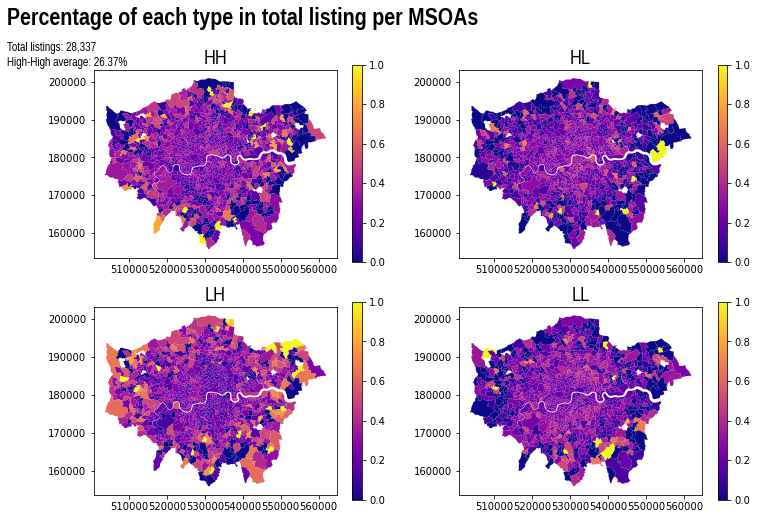

In [423]:
f,axes = plt.subplots(2,2,figsize=(12,8))

quar_density.plot(column='HHper', ax=axes[0,0], legend=True, cmap='plasma')
axes[0,0].set_title('HH', size=20, **afont)

quar_density.plot(column='HLper', ax=axes[0,1], legend=True, cmap='plasma')
axes[0,1].set_title('HL', size=20, **afont)

quar_density.plot(column='LHper', ax=axes[1,0], legend=True, cmap='plasma')
axes[1,0].set_title('LH', size=20, **afont)

quar_density.plot(column='LLper', ax=axes[1,1], legend=True, cmap='plasma')
axes[1,1].set_title('LL', size=20, **afont)

f.suptitle('Percentage of each type in total listing per LSOAs', x=0.025, ha='left', size=24, **tfont)

plt.figtext(x=0.025, y=0.92, linespacing=1.4, va='top', size=12, 
            s=f"Total listings: {quar_density['count'].sum():,.0f}\nHigh-High average: {quar_density['HHper'].mean()*100:,.2f}%", **bfont);

This result shows that the high counts of listings in inner London are mostly highly occupied and available when comparing to other 3 maps.  However, those 4 different types in inner London LSOAs are largely equal ratio. 

Outer London has higher proportion of low occupancy high availability listings, indicating low intensity as tourists' choice for stay. 